In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('images') if isfile(join('images', f))])

In [3]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    #image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    blurred = cv2.blur(gradient, (9, 9))
    ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    #closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    #opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
    dilated = cv2.dilate(opened, kernel, iterations=3)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 396.  254.]
 [1293.  250.]
 [ 400. 1128.]
 [1297. 1124.]]
Wall time: 130 ms


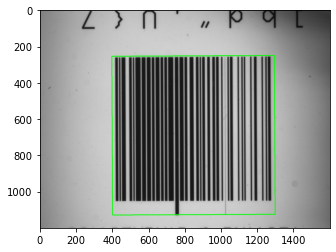

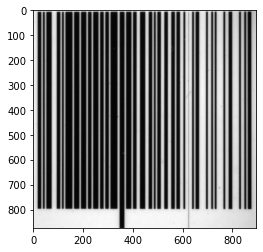

In [4]:
%%time
bound_box(f'images/{images_paths[0]}')

[[ 344.  281.]
 [1244.  282.]
 [ 344. 1089.]
 [1244. 1089.]]
Wall time: 114 ms


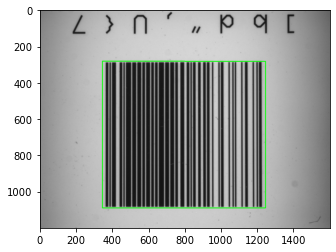

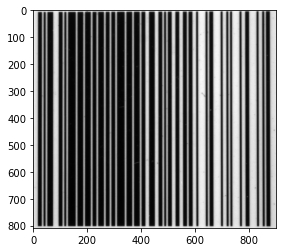

In [5]:
%%time
bound_box(f'images/{images_paths[1]}')

[[ 196.  236.]
 [1039.  231.]
 [ 199.  759.]
 [1042.  754.]]
Wall time: 95.5 ms


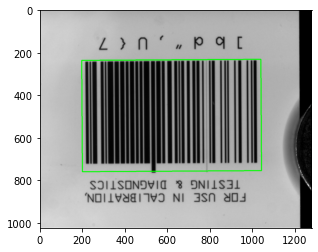

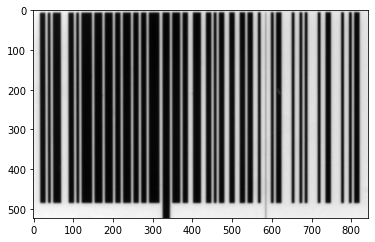

In [6]:
%%time
bound_box(f'images/{images_paths[2]}')

[[127. 252.]
 [970. 252.]
 [127. 745.]
 [970. 745.]]
Wall time: 69.8 ms


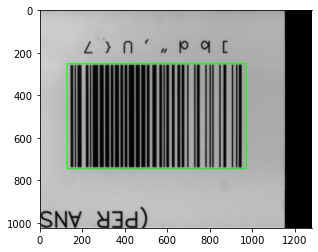

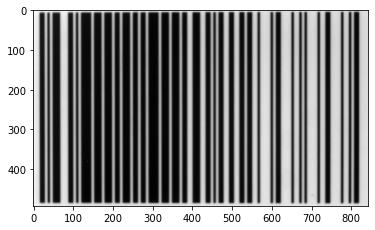

In [7]:
%%time
bound_box(f'images/{images_paths[3]}')

[[332. 165.]
 [903. 167.]
 [331. 690.]
 [901. 691.]]
Wall time: 94.9 ms


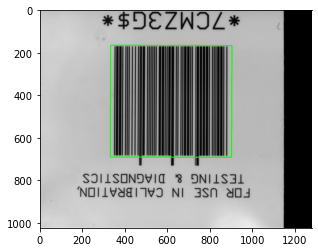

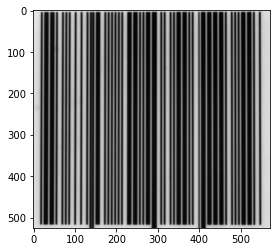

In [8]:
%%time
bound_box(f'images/{images_paths[4]}')

[[339. 245.]
 [911. 245.]
 [339. 769.]
 [911. 769.]]


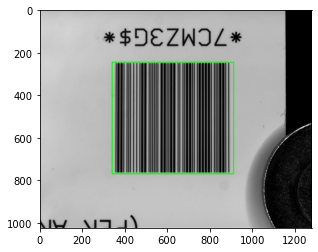

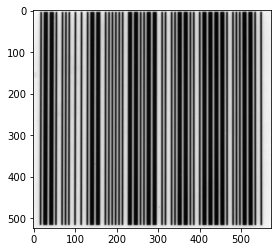

In [9]:
bound_box(f'images/{images_paths[5]}')

[[ 159.  281.]
 [1100.  279.]
 [ 161.  850.]
 [1101.  848.]]


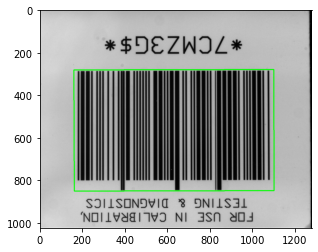

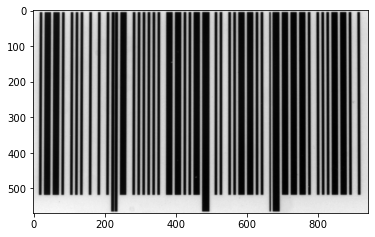

In [10]:
bound_box(f'images/{images_paths[6]}')

[[ 147.  268.]
 [1091.  270.]
 [ 146.  793.]
 [1090.  795.]]


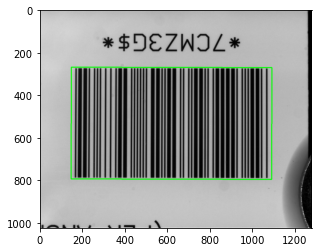

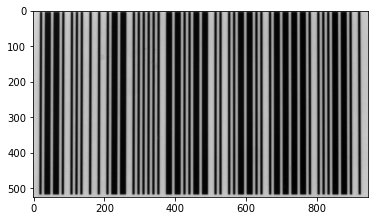

In [11]:
bound_box(f'images/{images_paths[7]}')

[[ 147.  268.]
 [1091.  270.]
 [ 146.  793.]
 [1090.  795.]]


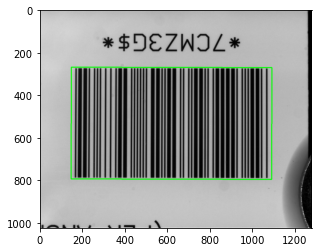

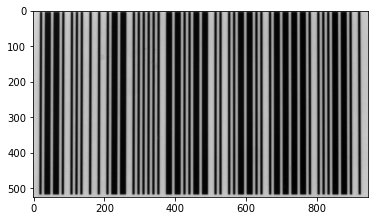

In [12]:
bound_box(f'images/{images_paths[7]}')

[[328. 330.]
 [972. 334.]
 [325. 783.]
 [969. 787.]]


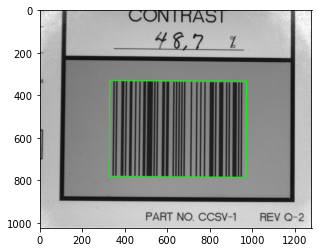

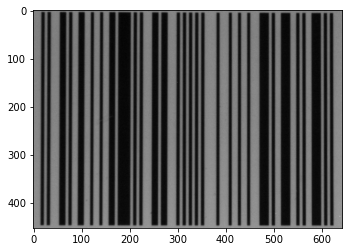

In [13]:
bound_box(f'images/{images_paths[8]}')

[[340. 249.]
 [980. 258.]
 [334. 723.]
 [973. 732.]]


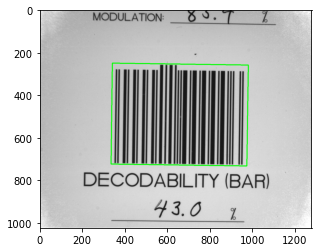

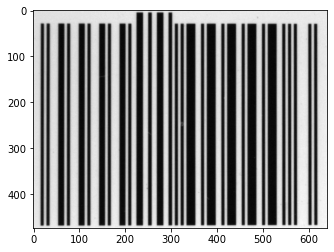

In [14]:
bound_box(f'images/{images_paths[9]}')

In [15]:
print(f'images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [16]:
#bound_box(f'images/{images_paths[10]}')

[[232. 261.]
 [954. 258.]
 [234. 760.]
 [956. 757.]]


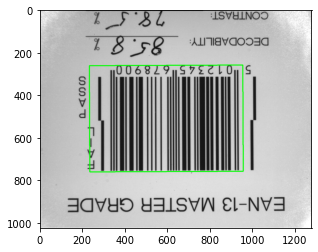

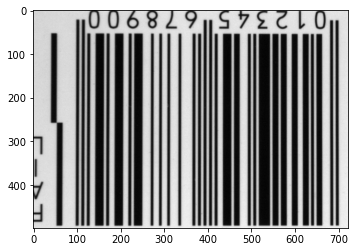

In [17]:
bound_box(f'images/{images_paths[11]}')

In [18]:
#bound_box(f'images/{images_paths[12]}')

[[  96.  113.]
 [1294.  115.]
 [  95.  314.]
 [1293.  316.]]


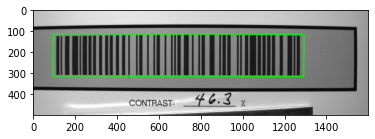

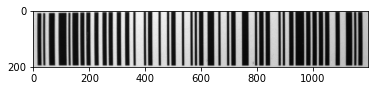

In [19]:
bound_box(f'images/{images_paths[13]}')

[[ 159.  140.]
 [1351.  140.]
 [ 159.  340.]
 [1351.  340.]]


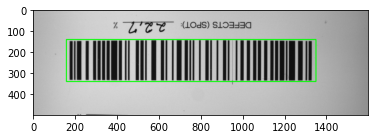

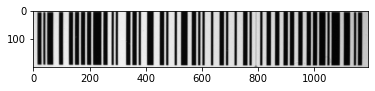

In [20]:
bound_box(f'images/{images_paths[14]}')

[[ 173.  162.]
 [1384.  149.]
 [ 175.  366.]
 [1386.  352.]]


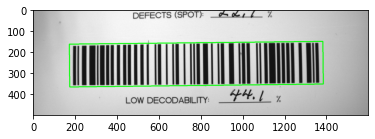

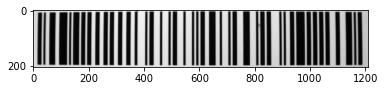

In [21]:
bound_box(f'images/{images_paths[15]}')

[[ 197.  136.]
 [1391.  136.]
 [ 197.  336.]
 [1391.  336.]]


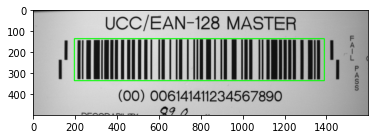

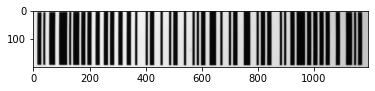

In [22]:
bound_box(f'images/{images_paths[16]}')

[[ 193.  139.]
 [1351.  120.]
 [ 197.  389.]
 [1355.  370.]]


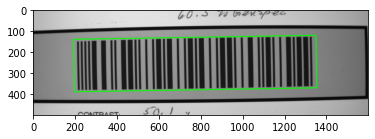

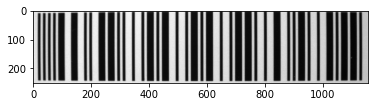

In [23]:
bound_box(f'images/{images_paths[17]}')

[[ 195.  124.]
 [1357.  112.]
 [ 197.  374.]
 [1359.  363.]]


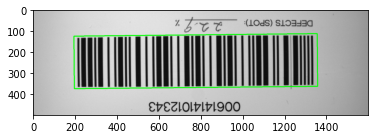

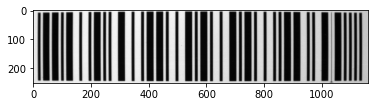

In [24]:
bound_box(f'images/{images_paths[18]}')

[[ 228.   54.]
 [1386.   54.]
 [ 228.  303.]
 [1386.  303.]]


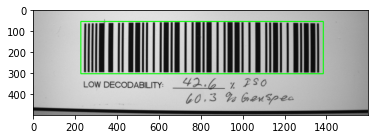

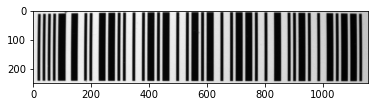

In [25]:
bound_box(f'images/{images_paths[19]}')

[[ 245.  137.]
 [1407.  124.]
 [ 248.  387.]
 [1410.  374.]]


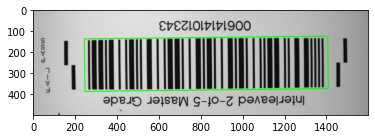

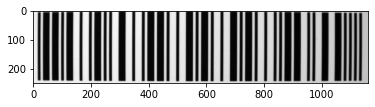

In [26]:
bound_box(f'images/{images_paths[20]}')

In [27]:
print(f'images/{images_paths[21]}')

images/TestChart.xls


In [28]:
#bound_box(f'images/{images_paths[21]}')

[[239. 187.]
 [824. 182.]
 [243. 646.]
 [828. 641.]]


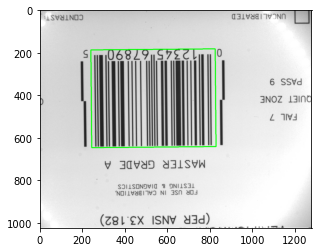

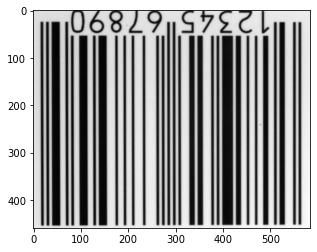

In [29]:
bound_box(f'images/{images_paths[22]}')

[[239. 187.]
 [824. 182.]
 [243. 646.]
 [828. 641.]]


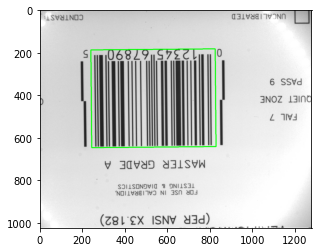

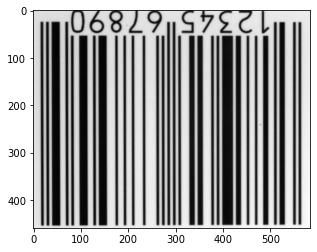

In [30]:
bound_box(f'images/{images_paths[22]}')

[[311. 279.]
 [897. 285.]
 [307. 739.]
 [892. 744.]]


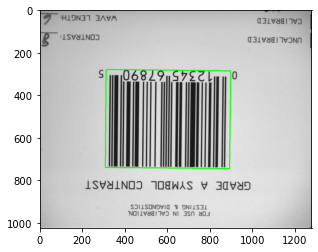

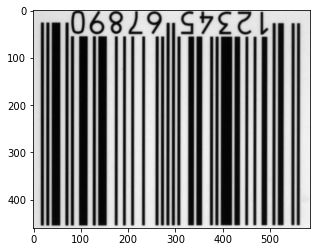

In [31]:
bound_box(f'images/{images_paths[23]}')

[[345. 275.]
 [928. 285.]
 [338. 734.]
 [920. 744.]]


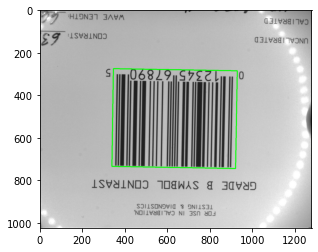

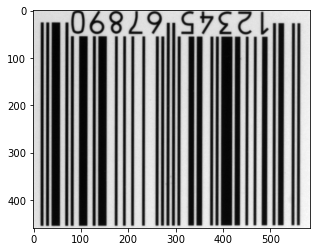

In [32]:
bound_box(f'images/{images_paths[24]}')

[[352. 280.]
 [936. 282.]
 [351. 736.]
 [935. 738.]]


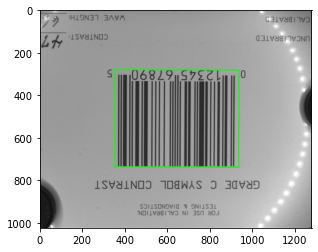

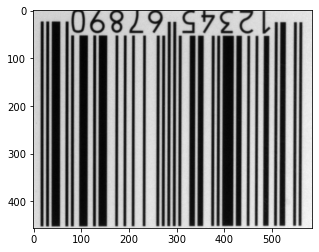

In [33]:
bound_box(f'images/{images_paths[25]}')

[[294. 255.]
 [876. 276.]
 [277. 714.]
 [859. 735.]]


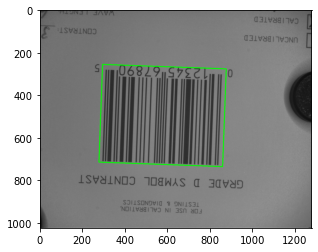

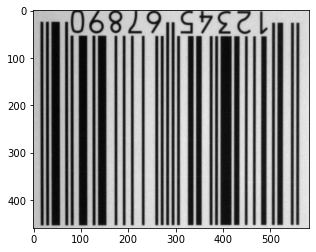

In [34]:
bound_box(f'images/{images_paths[26]}')

[[329. 273.]
 [911. 283.]
 [322. 724.]
 [904. 734.]]


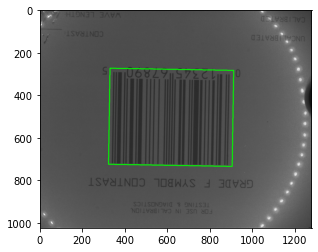

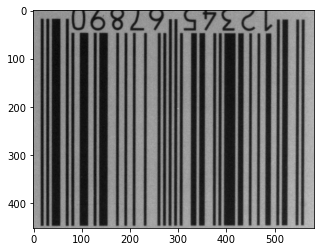

In [35]:
bound_box(f'images/{images_paths[27]}')

[[323. 268.]
 [908. 275.]
 [318. 730.]
 [903. 737.]]


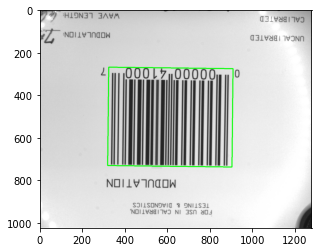

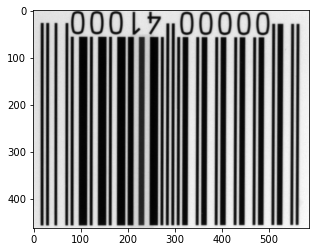

In [36]:
bound_box(f'images/{images_paths[28]}')

[[323. 273.]
 [908. 283.]
 [315. 735.]
 [900. 746.]]


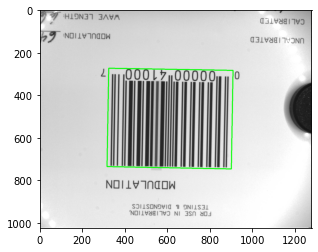

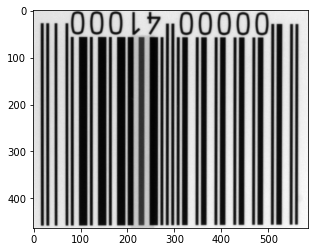

In [37]:
bound_box(f'images/{images_paths[29]}')

[[320. 284.]
 [905. 294.]
 [311. 745.]
 [897. 756.]]


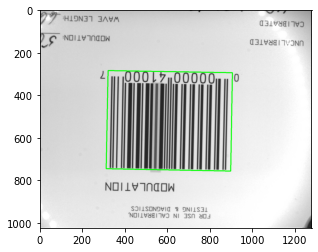

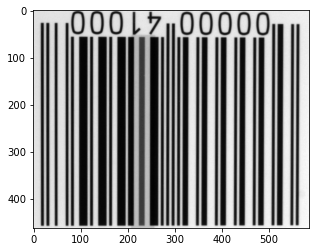

In [38]:
bound_box(f'images/{images_paths[30]}')

[[329. 272.]
 [912. 288.]
 [316. 734.]
 [899. 750.]]


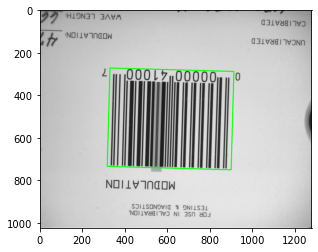

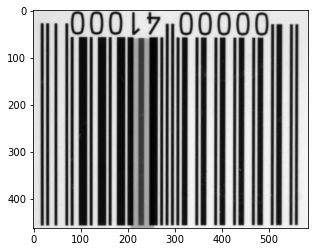

In [39]:
bound_box(f'images/{images_paths[31]}')

[[329. 265.]
 [913. 265.]
 [329. 726.]
 [913. 726.]]


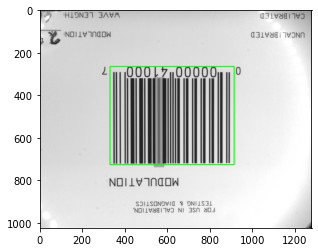

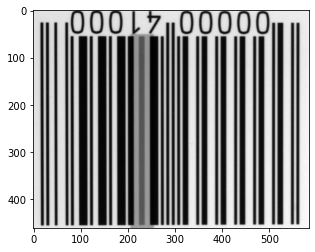

In [40]:
bound_box(f'images/{images_paths[32]}')

[[341. 271.]
 [925. 277.]
 [336. 752.]
 [920. 758.]]


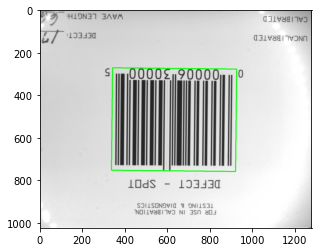

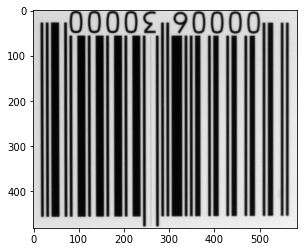

In [41]:
bound_box(f'images/{images_paths[34]}')

[[341. 262.]
 [925. 269.]
 [335. 743.]
 [919. 750.]]


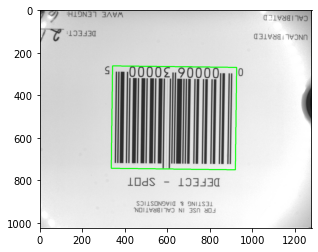

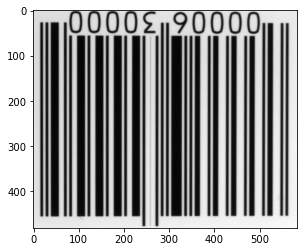

In [42]:
bound_box(f'images/{images_paths[35]}')

[[328. 265.]
 [912. 265.]
 [328. 747.]
 [912. 747.]]


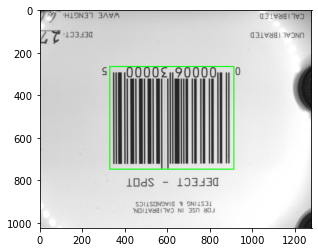

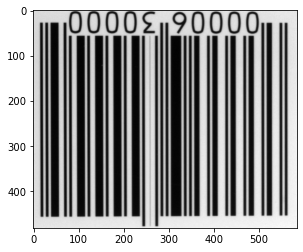

In [43]:
bound_box(f'images/{images_paths[36]}')

[[316. 272.]
 [899. 272.]
 [316. 754.]
 [899. 754.]]


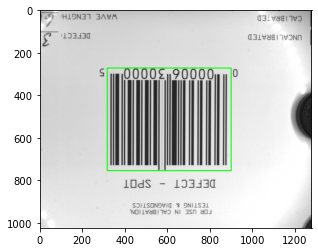

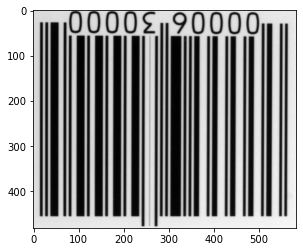

In [44]:
bound_box(f'images/{images_paths[37]}')

[[327. 274.]
 [912. 274.]
 [327. 756.]
 [912. 756.]]


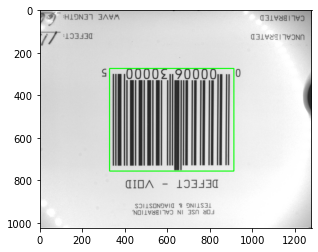

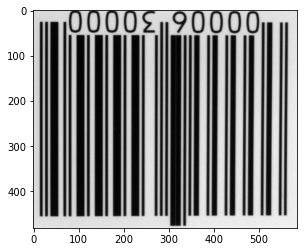

In [45]:
bound_box(f'images/{images_paths[38]}')

[[331. 265.]
 [916. 272.]
 [325. 747.]
 [910. 754.]]


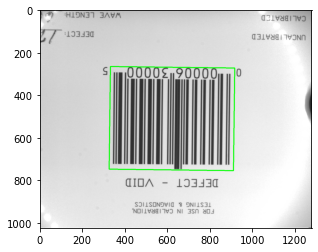

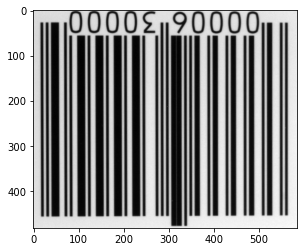

In [46]:
bound_box(f'images/{images_paths[39]}')

[[295. 275.]
 [880. 279.]
 [292. 757.]
 [877. 760.]]


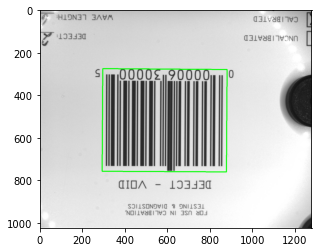

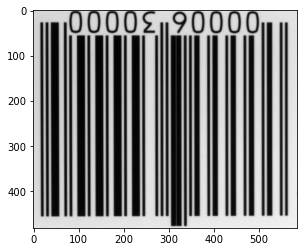

In [47]:
bound_box(f'images/{images_paths[40]}')

[[295. 275.]
 [880. 279.]
 [292. 757.]
 [877. 760.]]


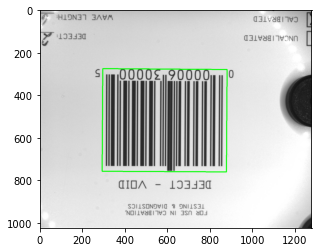

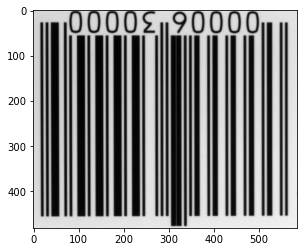

In [48]:
bound_box(f'images/{images_paths[40]}')

[[284. 268.]
 [870. 266.]
 [286. 749.]
 [871. 747.]]


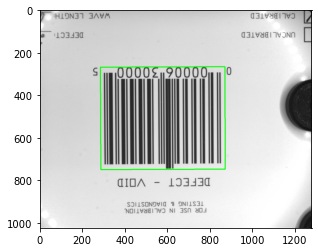

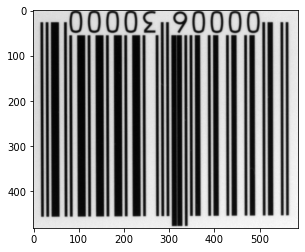

In [49]:
bound_box(f'images/{images_paths[41]}')

[[282. 264.]
 [867. 264.]
 [282. 746.]
 [867. 746.]]


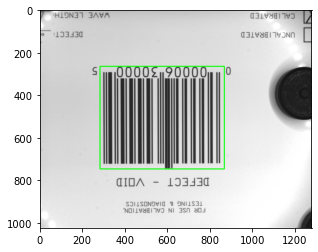

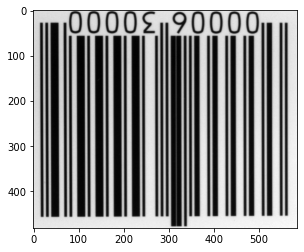

In [50]:
bound_box(f'images/{images_paths[42]}')

[[277. 261.]
 [862. 261.]
 [277. 722.]
 [862. 722.]]


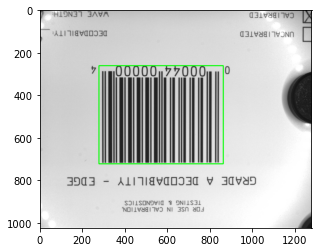

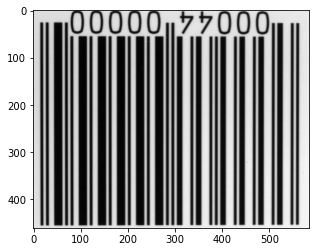

In [51]:
bound_box(f'images/{images_paths[43]}')

[[277. 261.]
 [862. 261.]
 [277. 722.]
 [862. 722.]]


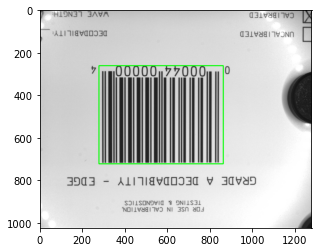

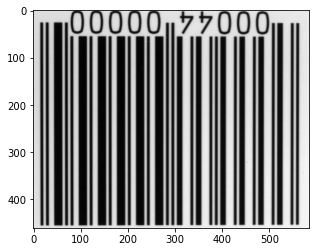

In [52]:
bound_box(f'images/{images_paths[43]}')

[[287. 266.]
 [872. 270.]
 [284. 727.]
 [869. 731.]]


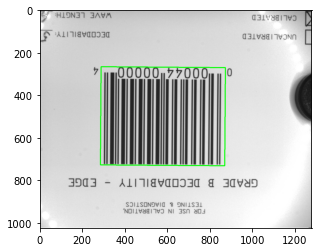

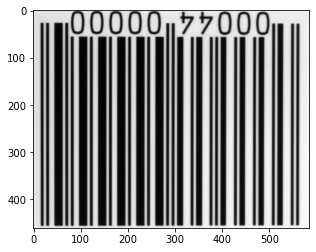

In [53]:
bound_box(f'images/{images_paths[44]}')

[[276. 278.]
 [861. 281.]
 [273. 739.]
 [859. 743.]]


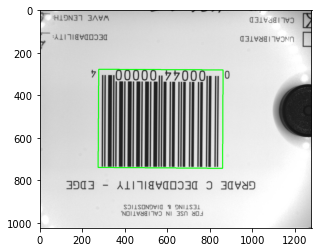

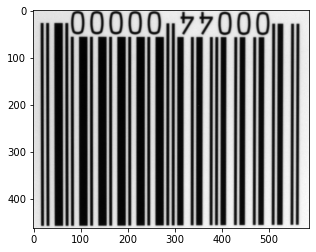

In [54]:
bound_box(f'images/{images_paths[45]}')

[[260. 267.]
 [846. 275.]
 [254. 729.]
 [839. 737.]]


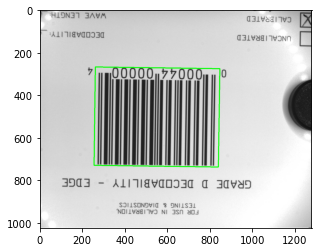

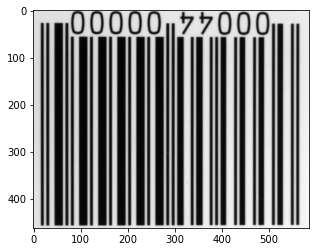

In [55]:
bound_box(f'images/{images_paths[46]}')

[[254. 275.]
 [841. 280.]
 [251. 737.]
 [837. 742.]]


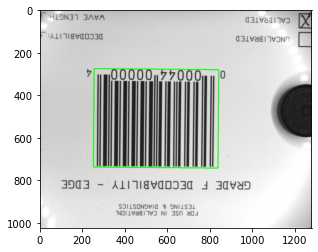

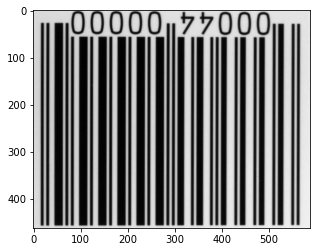

In [56]:
bound_box(f'images/{images_paths[47]}')

[[249. 273.]
 [835. 281.]
 [243. 735.]
 [829. 743.]]


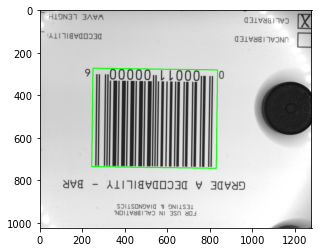

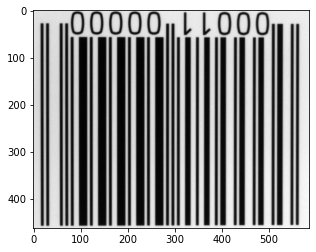

In [57]:
bound_box(f'images/{images_paths[48]}')

[[253. 274.]
 [839. 280.]
 [247. 737.]
 [833. 743.]]


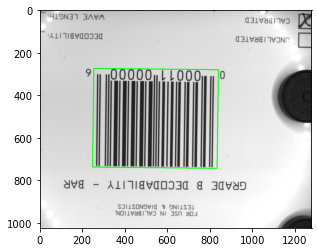

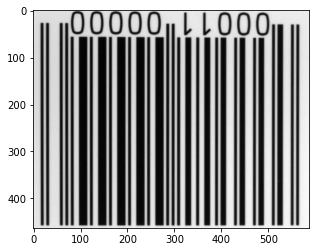

In [58]:
bound_box(f'images/{images_paths[49]}')

[[277. 252.]
 [863. 260.]
 [271. 714.]
 [857. 721.]]


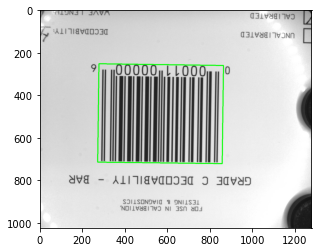

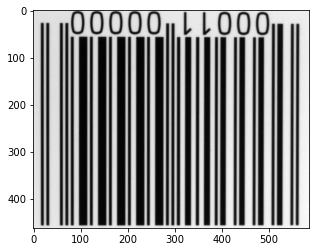

In [59]:
bound_box(f'images/{images_paths[50]}')

[[279. 261.]
 [865. 269.]
 [273. 724.]
 [859. 732.]]


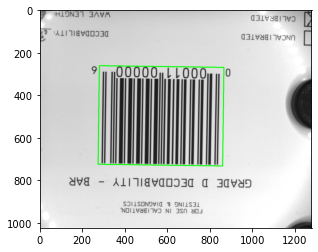

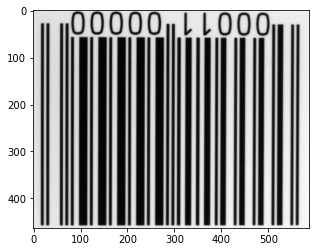

In [60]:
bound_box(f'images/{images_paths[51]}')

[[293. 264.]
 [878. 266.]
 [291. 725.]
 [876. 728.]]


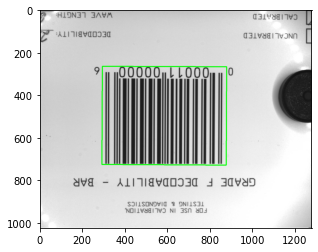

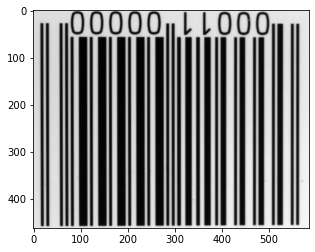

In [61]:
bound_box(f'images/{images_paths[52]}')

[[ 94.  40.]
 [260.  40.]
 [ 94. 153.]
 [260. 153.]]
Wall time: 42.4 ms


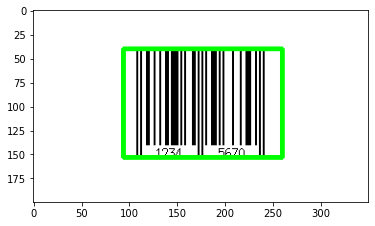

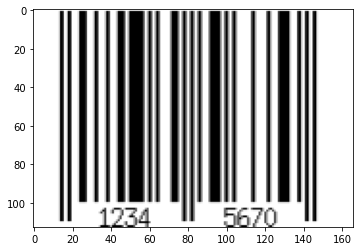

In [62]:
%%time
bound_box('other images/1.png')

[[ 608.  432.]
 [1069.  445.]
 [ 598.  789.]
 [1059.  802.]]
Wall time: 143 ms


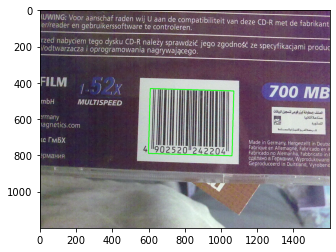

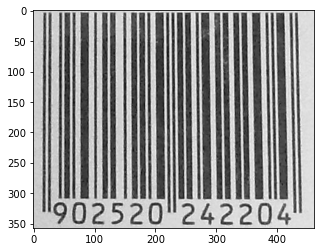

In [63]:
%%time
bound_box('other images/2.jpg')

[[ 734. -349.]
 [1755.  419.]
 [ -62.  708.]
 [ 958. 1477.]]
Wall time: 128 ms


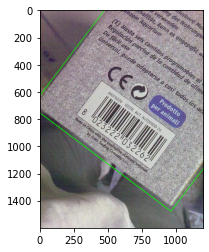

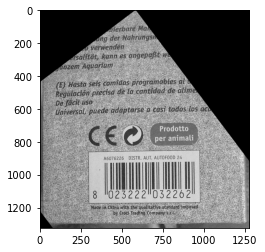

In [64]:
%%time
bound_box('other images/3.jpg')  # NO ROTATION INVARIANCE